#**Cat and Dog Image Classifier**

The model classify with Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time.

The structure of the dataset files looks like this (The test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

Tweak epochs and batch size is not required.

---

##Importing Required Libraries

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

##Downloading the data and sets key variables.

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2021-01-06 07:19:39--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1     [            <=>     ]  67.43M  1.22MB/s    in 55s     

2021-01-06 07:20:34 (1.23 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##Verifying the number of files of each directory 

In [ ]:
print(total_train)
print(total_val)
print(total_test)
print(train_dir)
print(validation_dir)
print(test_dir)

2001
1001
51
cats_and_dogs/train
cats_and_dogs/validation
cats_and_dogs/test


##Creating image generators for each of the image data sets. 

`ImageDataGenerator` read / decode the images and convert them into floating point tensors.

```
rescale
rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
```

www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

---
`flow_from_directory` method generates a tf.data.Dataset from image files in a directory.

```
directory
Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.

target_size
Either None (default to original size) or tuple of ints (img_height, img_width).

batch_size
Size of the batches of data. Default: 32.

class_mode
if class_mode is "binary" it must include the given y_col column with class values as strings.

shuffle
Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.
```
https://keras.io/api/preprocessing/image/

---

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1.0/255.0)


train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True
    )
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True
    )

test_data_gen = test_image_generator.flow_from_directory(
    directory = PATH, 
    classes=['test'], 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=1, 
    class_mode=None, 
    shuffle=False
    )


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


##Plotting 5 random images.

The `plotImages` function is used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional.


---



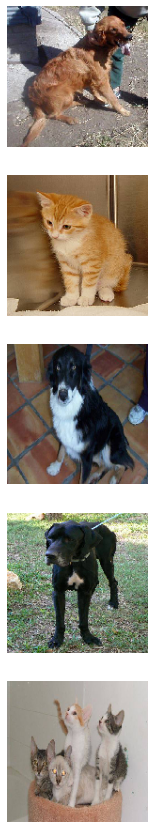

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


##Recreating training data

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Adding random transformations as arguments to `ImageDataGenerator`.

---




In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1.0/255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    rotation_range=40
    )                                          


`train_data_gen` is created with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

---



Found 2000 images belonging to 2 classes.


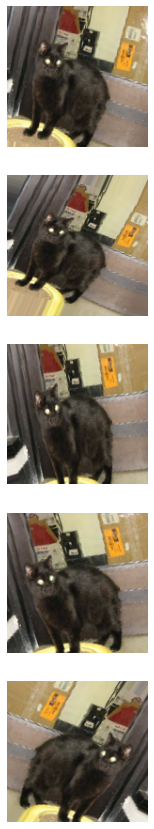

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)


##Creating the model for the neural network

The neural network outputs class probabilities.

It use the Keras Sequential model and involve a stack of Conv2D and MaxPooling2D layers and a fully connected layer on top that is activated by a ReLU activation function.

The model is compile by passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

https://keras.io/api/optimizers/

The cross-entropy loss is commonly use when there are only two label classes (assumed to be 0 and 1)

https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class

---



In [ ]:
model = Sequential()


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

##Train the network.
The `model` is train the network with the `fit` method. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

```
validation_data
Data on which to evaluate the loss and any model metrics at the end of each epoch.

epochs
Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.

steps_per_epoch
Integer or None. Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.

validation_steps
Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

verbose
0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
```

https://keras.io/api/models/model_training_apis/

---



In [ ]:
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=epochs,
                    steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
                    validation_steps=val_data_gen.n//val_data_gen.batch_size, 
                    verbose=1
                    )

Epoch 1/15
15/15 [==============================] - 93s 6s/step - loss: 1.2154 - accuracy: 0.5095 - val_loss: 0.6938 - val_accuracy: 0.4900
Epoch 2/15
15/15 [==============================] - 94s 6s/step - loss: 0.6937 - accuracy: 0.5089 - val_loss: 0.6922 - val_accuracy: 0.6038
Epoch 3/15
15/15 [==============================] - 90s 6s/step - loss: 0.6926 - accuracy: 0.5411 - val_loss: 0.6921 - val_accuracy: 0.4989
Epoch 4/15
15/15 [==============================] - 91s 6s/step - loss: 0.6924 - accuracy: 0.5166 - val_loss: 0.6882 - val_accuracy: 0.5993
Epoch 5/15
15/15 [==============================] - 91s 6s/step - loss: 0.6891 - accuracy: 0.5323 - val_loss: 0.6784 - val_accuracy: 0.5212
Epoch 6/15
15/15 [==============================] - 91s 6s/step - loss: 0.6791 - accuracy: 0.5508 - val_loss: 0.6748 - val_accuracy: 0.5435
Epoch 7/15
15/15 [==============================] - 91s 6s/step - loss: 0.6778 - accuracy: 0.5531 - val_loss: 0.6450 - val_accuracy: 0.6295
Epoch 8/15
15/15 [==

##Accuracy and loss.
The next cell to visualize the accuracy and loss of the model.

---



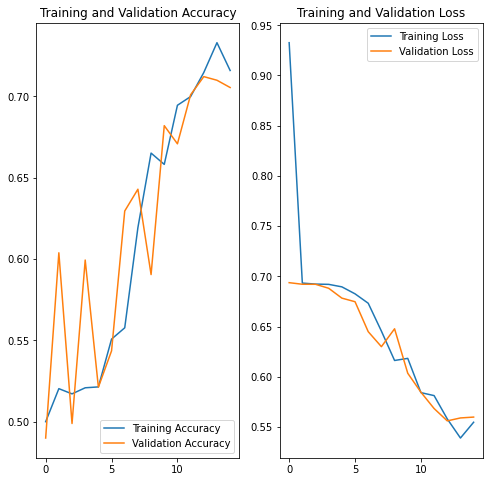

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Prediction.

Prediction is the final step and our expected outcome of the model generation. Keras provides a method, predict to get the prediction of the trained model.

This cell get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` are a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

You should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above. More training images could lead to a higher accuracy.

https://keras.rstudio.com/reference/predict.keras.engine.training.Model.html

---



In [ ]:
pred=model.predict(test_data_gen, verbose=1)

50/50 [==============================] - 1s 16ms/step


In [ ]:
predicted_class = model.predict_classes(test_data_gen)
predicted_class

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0])

In [ ]:
probabilities = predicted_class.tolist()

In [ ]:
actual_probabilities = [np.max(vector) for vector in pred]

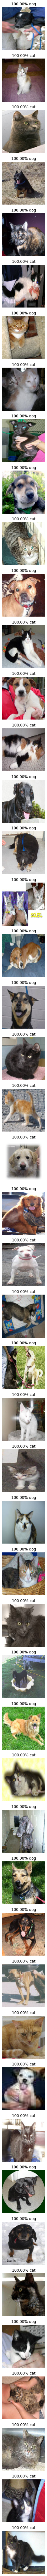

In [ ]:
plotImages([test_data_gen[i][0] for i in range(50)], predicted_class)

##Test the model.

This final cell tells if the challenge is passed.

---



In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.76% of the images of cats and dogs.
You passed the challenge!
